#### Part 1: Read cell body position from .apo files, downsample and save them as txt file for applying inverse transformation

In [1]:
import Neuron_analysis as na
from Neuron_analysis import *

import os
import pandas as pd
import re

import tkinter as tk
import tkinter.filedialog as fdialog
from tkinter import simpledialog

import skimage

import cc3d

import numpy as np
import matplotlib.pyplot as plt

from read_roi import read_roi_file

In [2]:
indir = fdialog.askdirectory(title='Select the directories with all the cell bodies.apo')
outdir = fdialog.askdirectory(title='Select the output directory to store your file')

files = os.listdir(indir)

In [69]:
def prepare_cellbody(indir,anno_file,outdir):
    anno=open(os.path.join(indir,anno_file),'r')
    anno_data=anno.readlines()
 
    headings=anno_data[0].rstrip('\n').split(',')
    annotations=[lines.rstrip('\n').split(',') for lines in anno_data[1:]]
    annotation_df=pd.DataFrame(annotations, columns=headings)
    
    cell_body= annotation_df[annotation_df.color_g=='255']
    #pickout only green points!
    
    # find the coordinates and downsample it! these values are based on xy= 0.6 z= 5, and downsampling to 25 xyz
    ds_x= pd.to_numeric(cell_body['x'])//41
    ds_y= pd.to_numeric(cell_body['y'])//41
    ds_z= pd.to_numeric(cell_body['z'])//5

    x=ds_x.astype(int).astype(str)
    y=ds_y.astype(int).astype(str)
    z=ds_z.astype(int).astype(str)
    
    m=re.search('\D{2}[0-9]{3}', anno_file)
    mouse_name=m[0]

    out_name=os.path.join(outdir,mouse_name+'cellbody.txt')

    f=open(out_name,'w+')
    f.write('point'+'\n')
    f.write('1'+'\n') # by default there is only 1 cell body, hence only 1 point here
    f.write(x.values[0]+ ' ' + y.values[0]+ ' '+ z.values[0])
    f.close()
    return
    

In [70]:
for items in files:
    prepare_cellbody(indir, items, outdir)

### Part2  : (after transformation by transformix) extract the transformed points, refill y section (because we cropped the template for registration). 
Then write as a single file containing brain ID and cell body location

___Work in progress___

In [3]:
brain_id= ['AL175', 'AL223','AL230', 'AL236','AL242', 'AL244', 'AL261']
#missing 'AL225' 
cb_file=f'D:\{brain_id[1]}\points\cellbody\outputpoints.txt'

In [4]:
all_points=[]

for items in brain_id:
    this_file=cb_file=f'D:\{items}\points\cellbody\outputpoints.txt'
    
    template_file = [x for x in os.listdir(f'D:\{items}\\') if 'template' in x]
    to_add=na.find_crop(template_file[0])
  
    with open(cb_file,'r') as output:
        outputpoint= output.readlines()

    for lines in outputpoint:
        m=re.search("(?:OutputIndexFixed = \[ )([0-9]+ [0-9]+ [0-9]+)", lines).groups(0)
        this_line= str(m[0]).split(' ')
        mypoints= [int(stuff) for stuff in this_line]
        mypoints[1]= mypoints[1]+to_add
        mypoints.insert(0, items)
        all_points.append(mypoints)
        
# the coordiates are arranged in x,y and z

In [5]:
all_points

[['AL175', 92, 283, 52],
 ['AL223', 99, 279, 47],
 ['AL230', 88, 275, 56],
 ['AL236', 104, 279, 40],
 ['AL242', 136, 263, 33],
 ['AL244', 86, 302, 47],
 ['AL261', 123, 261, 42]]

In [8]:
cell_bodies= pd.DataFrame(all_points, columns= ['name', 'x', 'y', 'z'])

In [10]:
cell_bodies

name    x    y   z
0  AL175   92  283  52
1  AL223   99  279  47
2  AL230   88  275  56
3  AL236  104  279  40
4  AL242  136  263  33
5  AL244   86  302  47
6  AL261  123  261  42

## (old)Part for viral cellbody ROIs (after segmentation and curation in LabKit)

ImageJ plugin https://imagej.net/plugins/labkit/

In [95]:
outdir = fdialog.askdirectory(title='Select the output directory to store your file')

In [73]:
image_name = fdialog.askopenfile(title='Select the binary image').name
mouse_name=na.find_mousename(image_name)


In [107]:
def prepare_cellbody_virus(tiff_file, threshold=5):
    '''From curated segmentation tiff file, find connected components(3d) with their area and centeroid.
    
    threshold: connected components with numbers of pixels below this number will get removed
    
    saves .txt file compatible for transformix (and downsampled to 25um space) and a .csv file listing the area and the centroid x,y,z coordinate (not downsampled) for each component
    '''
    
    im= skimage.io.imread(tiff_file) 
        
    labels=skimage.measure.label(im)
    info= skimage.measure.regionprops(labels)
    
    real_cells= [items for items in info if items.area>threshold]
    # remove connected components that are less than 5 pixels for example
    areas=[item.area for item in real_cells]
    
    center= [item.centroid for item in real_cells]
    center=np.asarray(center)
    
    headings=['x', 'y', 'z']
    #points=[lines.rstrip('\n').split(',') for lines in anno_data[1:]]
    centroid_df=pd.DataFrame(center, columns=headings)
    centroid_df['area']= areas
    return centroid_df

def refill_roi(centroid_df):
    
    ''' Find x, y, z section to refill from .roi file (account for x and y) and substack file name (account for z)
    refill the input dataframe's 'x', 'y', 'z' to match the original image size. Input data frame is usually an output from prepare_cellbody_virus
    '''
    roi_name = fdialog.askopenfile(title='Select the roi').name
    roi = read_roi_file(roi_name)
    name=list(roi.keys())[0]
    x_add=roi[name]['left']-1
    y_add=roi[name]['top']-1
    substack_name = fdialog.askopenfile(title='Select the substack used for cellbody segmentation').name
    m= re.search("(?<=_)[0-9]{1,3}.[0-9]{1,3}",substack_name)[0]
    to_add= m.split('-')
    lead= int(to_add[0])-1
    centroid_df['x']+= x_add
    centroid_df['y']+= y_add
    centroid_df['z']+= lead
    
    return centroid_df

def make_transformix_txt(centroid_df,mouse_name): #work in progress

    # find the coordinates and downsample it! these values are based on xy= 0.6 z= 5, and downsampling to 25 xyz
    ds_x= pd.to_numeric(centroid_df['x'])//5
    ds_y= pd.to_numeric(centroid_df['y'])//5
    ds_z= pd.to_numeric(centroid_df['z'])//5

    x=ds_x.astype(int).astype(str)
    y=ds_y.astype(int).astype(str)
    z=ds_z.astype(int).astype(str)
    
    q = [' '.join(x) for x in zip(x,y,z)]
    num_row=len(q)

    out_name=os.path.join(outdir,mouse_name+'cellbody.txt')

    f=open(out_name,'w+')
    f.write('point'+'\n')
    f.write(str(num_row)+'\n')
    for lines in q:
        f.write(lines+'\n')
    f.close()
    
    return

In [91]:
cell_body=prepare_cellbody_virus(image_name, threshold=5)
cell_body

x           y           z  area
0      3.703704  180.407407  153.518519    27
1      7.030075  119.902256  150.300752   133
2     17.102345  137.281450  133.098081   469
3     14.987342  120.278481  143.550633   158
4     13.380952  121.492063  201.539683    63
..          ...         ...         ...   ...
176  128.333333   59.666667   43.875000    24
177  128.869565   80.630435   36.760870    46
178  132.437500   65.687500   47.875000    16
179  134.555556   74.888889   21.222222     9
180  134.888889   84.666667   48.777778     9

[181 rows x 4 columns]

In [92]:
cell_body_refill= refill_roi(cell_body)
cell_body_refill

In [98]:
out_name=os.path.join(outdir,mouse_name+'cellbody.csv')
cell_body_refill.to_csv(out_name)

In [108]:
make_transformix_txt(cell_body_refill,mouse_name)

## Part for rough injection site segmented with Labkit from registered downsampled images

In [2]:
import Neuron_analysis as na
from Neuron_analysis import *

import os
import pandas as pd
import re

import tkinter as tk
import tkinter.filedialog as fdialog
from tkinter import simpledialog

import skimage

import cc3d

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt

from tqdm import tqdm

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache


In [3]:
indir = fdialog.askdirectory(title='Select the directories with  the injection site tif stacks to be z filled')
outdir = fdialog.askdirectory(title='Select the output directory to store the results')

files = os.listdir(indir)

In [4]:
def prepare_injsite(tiff_file, lead, outdir): 
    #WORKINPROGRESS
    '''From injection site tiff file, find the cropped regions and add it back(so the dimension matches the full atlas)
    save as tiff file
    '''
    
    
    im= skimage.io.imread(tiff_file) 
    
    atlas_shape=(320, 528, 456)
    coords= np.argwhere(im>0)
    
    refilled_coords=np.zeros(atlas_shape)
    for lines in coords:
        refilled_coords[lines[0],lines[1]+lead, lines[2]]=255
        
    horizontal= np.int16(refilled_coords)

    out_name=os.path.basename(tiff_file)[:-4]
    skimage.io.imsave(f'{outdir}//{out_name}_full.tiff',horizontal)

    return 

In [5]:
for i in tqdm(files):
    

    tiff_file=os.path.join(indir,i) 
    mouse_name=na.find_mousename(i)

    template_dir= f'M:\\analysis\\Yanqi_Liu\\Viral_stacks\\{mouse_name}'
    template_name= [i for i in os.listdir(template_dir) if 'template_' in i]
    lead= na.find_crop(template_name[0])
    
    prepare_injsite(tiff_file, lead, outdir)    


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/viral_injsite_results//AL284_561_full.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
  7%|█████▉                                                                             | 1/14 [00:02<00:31,  2.40s/it]C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/viral_injsite_results//AL284_647_full.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
 14%|███████████▊                                                                       | 2/14 [00:04<00:25,  2.10s/it]C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/viral_injsite_results//AL286_647_full.tiff is a low contrast image
  warn('%s is a low contrast image' % fn

In [ ]:
# now use these injection site tiff with full dimension to find information
# number of voxels, centroid, centroid id, and voxel id
# organize in pandas dataframe and save as excel file

Coronal atlas has shape (528, 320, 456)
Converted to horizontal atlas with shape (456, 528, 320)


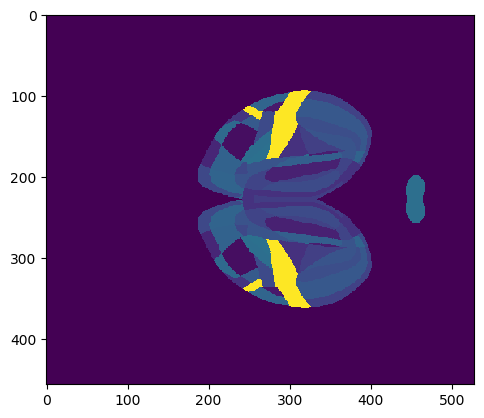

In [6]:
mcc = MouseConnectivityCache(resolution=25)

annot, annot_info = mcc.get_annotation_volume()

print('Coronal atlas has shape', annot.shape)

annot_h=np.moveaxis(annot, 2, 0) #reslice corontal atlas to horizontal atlas
print('Converted to horizontal atlas with shape', annot_h.shape)

plt.imshow(annot_h[:,:,36], interpolation='nearest', vmin=0, vmax=3000)
plt.show()
# although in this plot it looks like the image should rotate 90 degrees to the right but it actually matches the dimension of image

In [7]:
indir_injectionsite = fdialog.askdirectory(title='Select the directories with all the injection site tif FULL stacks')
# now indicate the folder contaning outputs from prepare_injsite. Now all tiff will have the same dimension as the full atlas
files = os.listdir(indir_injectionsite)
#full_file=os.path.join(indir_injectionsite, files[2])

In [8]:
d = {'Data_name':[], 'Total_voxels':[] , 'Centroid_location_1': [], 'Centroid_location_2': [], 'Centroid_location_3': [], 'Centroid_id':[],'Voxel_id':[] }
results=pd.DataFrame(data=d)

In [9]:
for i in tqdm(files):
    full_file=os.path.join(indir_injectionsite, i)    
    im= skimage.io.imread(full_file)
    # read the files
    
    labels_out = cc3d.connected_components(im,connectivity=6)
    stats = cc3d.statistics(labels_out)
    # find relevant info using cc3d
    
    centroid_round = stats['centroids'][1].astype(int)
    centroid_id = int(annot_h[(centroid_round[2]), centroid_round[1], centroid_round[0]])
    
    coords= np.argwhere(im>0) # find an atlas id for each coordinate
    points_in_atlas=[]
    for j in coords:
        points_in_atlas.append(int(annot_h[j[2], j[1],j[0]]))
        #note this order of dimensions
    unique, counts = np.unique(points_in_atlas, return_counts=True)
    id_count=dict(zip(unique, counts))
    
    results= results.append ({'Data_name':f'{i[:9]}', 'Total_voxels':stats['voxel_counts'][1],
                              'Centroid_location_1': centroid_round[2], 'Centroid_location_2': centroid_round[1], 'Centroid_location_3': centroid_round[0],
                              'Centroid_id':centroid_id, 'Voxel_id':[id_count] }, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [03:27<00:00,  5.61s/it]


In [10]:
results

Data_name  Total_voxels  Centroid_location_1  Centroid_location_2  \
0   AL207_647        6480.0                121.0                276.0   
1   AL208_647        1691.0                137.0                274.0   
2   AL209_647        4218.0                109.0                270.0   
3   AL210_647        1855.0                122.0                287.0   
4   AL211_647        1584.0                106.0                276.0   
5   AL213_647        2944.0                 98.0                272.0   
6   AL214_647        3679.0                133.0                272.0   
7   AL215_647        2543.0                102.0                279.0   
8   AL254_561        4580.0                 97.0                281.0   
9   AL255_561        9959.0                 76.0                284.0   
10  AL256_561        7322.0                 76.0                286.0   
11  AL257_561        4327.0                 79.0                263.0   
12  AL266_647       11292.0                112.0                295.0   
13  AL271_561        6001.0                 76.0                290.0   
14  AL273_647        3158.0                118.0                273.0   
15  AL274_561        2205.0                 77.0                284.0   
16  AL274_647        5471.0                102.0                283.0   
17  AL276_647        3114.0                106.0                314.0   
18  AL278_647        1221.0                 70.0                282.0   
19  AL279_647        6163.0                 62.0                287.0   
20  AL280_647        1642.0                 71.0                277.0   
21  AL281_647        1767.0                 72.0                283.0   
22  AL284_561        3014.0                114.0                284.0   
23  AL284_647        3382.0                 84.0                285.0   
24  AL285_647        2885.0                102.0                269.0   
25  AL286_647         919.0                 70.0                272.0   
26  AL287_647        8521.0                 84.0                298.0   
27  AL288_647        4016.0                 70.0                270.0   
28  AL289_647        8642.0                 78.0                292.0   
29  AL290_561         981.0                 65.0                272.0   
30  AL290_647        2523.0                 91.0                269.0   
31  AL291_561        2293.0                 98.0                278.0   
32  AL291_647        4092.0                 73.0                275.0   
33  AL292_561        1927.0                100.0                278.0   
34  AL292_647        2281.0                 66.0                281.0   
35  AL293_561         966.0                 63.0                303.0   
36  AL293_647        2848.0                 98.0                287.0   

    Centroid_location_3  Centroid_id  \
0                  60.0       1070.0   
1                  51.0       1111.0   
2                  69.0       1070.0   
3                  52.0       1070.0   
4                  66.0       1070.0   
5                  73.0       1070.0   
6                  54.0       1111.0   
7                  67.0       1070.0   
8                  46.0        201.0   
9                  61.0        201.0   
10                 63.0        201.0   
11                 60.0        981.0   
12                 58.0       1070.0   
13                 88.0       1090.0   
14                 63.0       1070.0   
15                106.0        862.0   
16                 80.0       1038.0   
17                 73.0  484682520.0   
18                 94.0       1090.0   
19                115.0        252.0   
20                 97.0       1090.0   
21                102.0       1090.0   
22                 75.0       1038.0   
23                102.0        862.0   
24                 84.0       1038.0   
25                111.0       1090.0   
26                 79.0       1070.0   
27                107.0       1090.0   
28                 91.0       1090.0   
29                 93.0      

In [11]:
results.to_excel(r'D:\viral_injectionsite\results.xlsx')

### For visualization and plotting!

In [1]:
import numpy as np
import numpy.ma as ma

from skimage import measure
import SimpleITK as sitk

import plotly
import plotly.offline
import plotly.graph_objects as go

import pandas as pd

In [2]:
atlas= sitk.ReadImage('D:\\Allenbrainatlas\\ARA_25_micron_mhd_ccf2017\\annotation_25_horizontal.mhd')
barrels= sitk.ReadImage('D:\\Barrels_map\\barrels_horizontal.mhd')

In [3]:
volume= sitk.GetArrayFromImage(atlas) # read the atlas image
x=ma.masked_greater(volume,0) #take every structure of the brain(anything greater than 0)
brain=x.mask

In [4]:
verts, faces, normals, values = measure.marching_cubes_lewiner(brain, level=None, spacing=(1.0, 1.0, 1.0),step_size=10)

In [5]:
barrels.GetSize()

(456, 320, 528)

In [16]:
brain.shape

(320, 528, 456)

In [5]:
barrels_array =  sitk.GetArrayFromImage(barrels)
#y=ma.masked_equal(barrels_array,0)
#barrels_mask=y.mask

#no need to convert to mask because barrels_horizontal.mhd is already a binary image

In [6]:
verts2, faces2, normals2, values2 = measure.marching_cubes_lewiner(barrels_array, level=None, spacing=(1.0, 1.0, 1.0),step_size=1)

In [7]:
s2=ma.masked_equal(volume,806) #take just layer 23 of S2 of the brain(id 806)
s2_mask= s2.mask

verts3, faces3, normals3, values3 = measure.marching_cubes_lewiner(s2_mask, level=None, spacing=(1.0, 1.0, 1.0),step_size=10)

False

In [8]:
data=pd.read_excel(r'D:\viral_injectionsite\results_expanded.xlsx',index_col=0)

In [9]:
legit_data= data[data['over_eighty']==True]

In [10]:
legit_data

Data_name  Total_voxels  Centroid_location_1  Centroid_location_2  \
0   AL207_647          6480                  121                  276   
2   AL209_647          4218                  109                  270   
4   AL211_647          1584                  106                  276   
5   AL213_647          2944                   98                  272   
7   AL215_647          2543                  102                  279   
8   AL254_561          4580                   97                  281   
9   AL255_561          9959                   76                  284   
10  AL256_561          7322                   76                  286   
11  AL257_561          4327                   79                  263   
14  AL273_647          3158                  118                  273   
15  AL274_561          2205                   77                  284   
16  AL274_647          5471                  102                  283   
18  AL278_647          1221                   70                  282   
20  AL280_647          1642                   71                  277   
21  AL281_647          1767                   72                  283   
24  AL285_647          2885                  102                  269   
25  AL286_647           919                   70                  272   
27  AL288_647          4016                   70                  270   
29  AL290_561           981                   65                  272   
30  AL290_647          2523                   91                  269   
31  AL291_561          2293                   98                  278   
33  AL292_561          1927                  100                  278   
34  AL292_647          2281                   66                  281   
36  AL293_647          2848                   98                  287   

    Centroid_location_3  Centroid_id  \
0                    60         1070   
2                    69         1070   
4                    66         1070   
5                    73         1070   
7                    67         1070   
8                    46          201   
9                    61          201   
10                   63          201   
11                   60          981   
14                   63         1070   
15                  106          862   
16                   80         1038   
18                   94         1090   
20                   97         1090   
21                  102         1090   
24                   84         1038   
25                  111         1090   
27                  107         1090   
29                   93         1035   
30                   68         1047   
31                   64         1047   
33                   62         1047   
34                   94         1035   
36                   59         1047   

                                             Voxel_id     Genotype  \
0   [{9: 23, 1038: 1543, 1047: 14, 1070: 3873, 111...      Sim1Cre   
2                  [{1038: 75, 1047: 11, 1070: 4132}]      Sim1Cre   
4                            [{1047: 94, 1070: 1490}]      Rbp4Cre   
5                            [{1047: 44, 1070: 2900}]      Tlx3Cre   
7                [{1038: 532, 1047: 1022, 1070: 989}]      Rbp4Cre   
8                 [{201: 2937, 981: 1217, 1047: 426}]  Rasgrf2dCre   
9   [{201: 6655, 806: 771, 873: 187, 981: 2043, 10...  Rasgrf2dCre   
10  [{201: 5013, 806: 926, 873: 92, 981: 513, 1035...  Rasgrf2dCre   
11                           [{201: 2459, 981: 1868}]  Rasgrf2dCre   
14            [{1038: 636, 1070: 2514, 182305705: 8}]      Sim1Cre   
15                           [{862: 1958, 1090: 247}]     Ntsr1Cre   
16  [{1038: 4515, 1062: 286, 1070: 587, 484682520:...     Ntsr1Cre   
18        [{1035: 68, 1047: 2, 1070: 52, 1090: 1099}]      Tlx3Cre   
20                 [{1035: 8, 1070: 100, 1090: 1534}]      Tlx3Cre   
21                           [{862: 185, 1090: 1582}]      Sim1Cre   
24                          [{1038: 2492, 1070: 393}]    

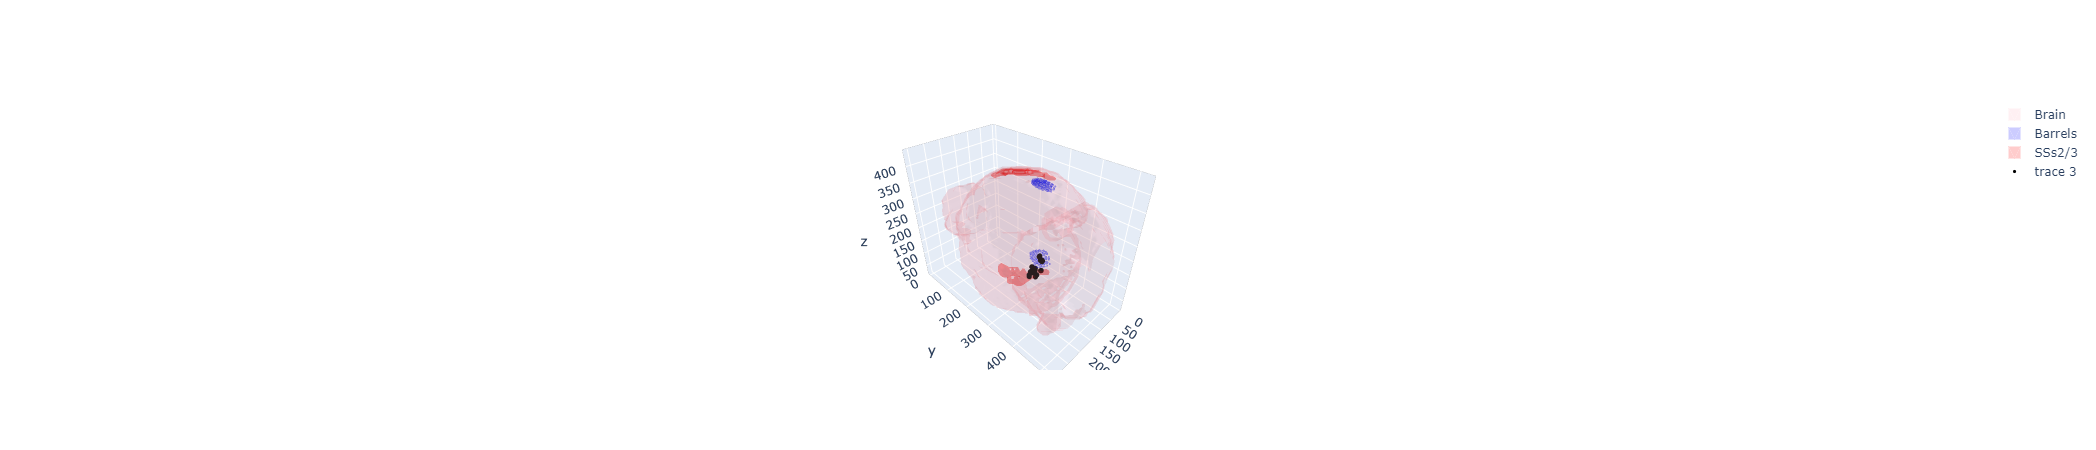

In [20]:
x, y, z = verts.T
i,j,k = faces.T
#Brain

#color=[1,2,3,4,5,6,7,8]

x2, y2, z2 = verts2.T
i2,j2,k2 = faces2.T
#barrels


x3, y3, z3 = verts3.T
i3,j3,k3 = faces3.T
#s2

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.20,
                               i=i,
                               j=j,
                            k=k,)])

fig.add_trace(go.Mesh3d(x=x2, y=y2, z=z2, color='blue', opacity=0.20,
                               i=i2,
                               j=j2,
                            k=k2,))

fig.add_trace(go.Mesh3d(x=x3, y=y3, z=z3, color='red', opacity=0.20,
                               i=i3,
                               j=j3,
                            k=k3,))

fig.add_trace(go.Scatter3d(z=legit_data['Centroid_location_3'], y=legit_data['Centroid_location_2'],x=legit_data['Centroid_location_1'],  mode='markers', hovertext=legit_data['Data_name'] ,marker=dict(size=3, color='black')))
#shift x and z to match the space of the allen atlas!

fig['data'][0]['showlegend'] = True
fig['data'][0]['name'] = 'Brain'

fig['data'][1]['showlegend'] = True
fig['data'][1]['name'] = 'Barrels'

fig['data'][2]['showlegend'] = True
fig['data'][2]['name'] = 'SSs2/3'

#fig['data'][2]['showlegend'] = True
#fig['data'][2]['name'] = 'Cell bodies'
# Have to go in and specify since the legends are not automatically displayed in this case

fig.show()
fig.write_html('test_cellbodies.html')